# Using a Modflow model as a stressmodel in Pastas

This notebook shows how to use a simple Modflow model as stress model in Pastas.

In [1]:
import pandas as pd
import pastas as ps
import matplotlib.pyplot as plt

from pastas.timer import SolveTimer
import pastas_plugins.modflow as ppmf

ps.set_log_level("ERROR")
%load_ext autoreload
%autoreload 2

array([[<Axes: title={'center': 'head'}, xlabel='date'>],
       [<Axes: title={'center': 'rain'}, xlabel='date'>],
       [<Axes: title={'center': 'evap'}, xlabel='date'>]], dtype=object)

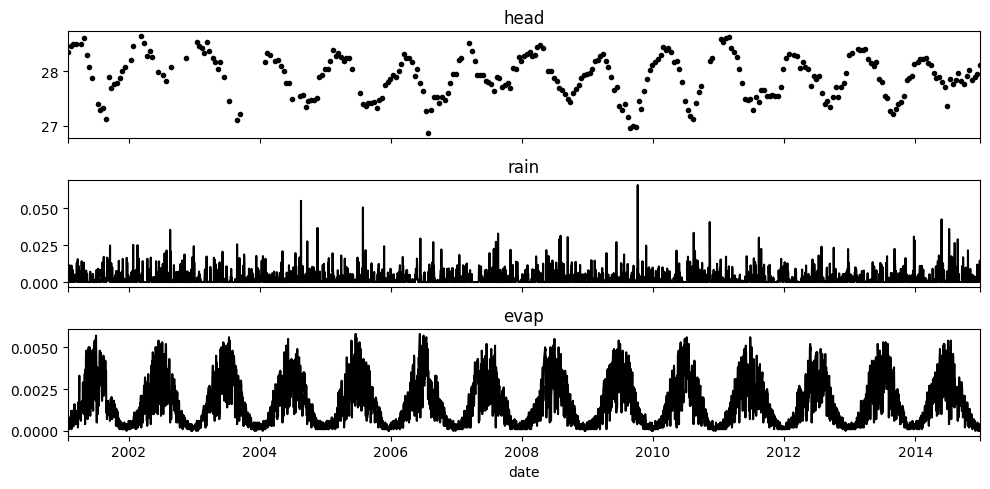

In [ ]:
#%%
tmin = pd.Timestamp("2001-01-01")
tmax = pd.Timestamp("2014-12-31")

tmin_wu = tmin - pd.Timedelta(days=3651)
tmin_wu = pd.Timestamp("1986-01-01")

head = (
    pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/head_nb1.csv",index_col="date", parse_dates=True)
    .squeeze()
    .loc[tmin:tmax]
)
prec = (
    pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/rain_nb1.csv", index_col="date", parse_dates=True)
    .squeeze()
    .loc[tmin_wu:tmax]
)
evap = (
    pd.read_csv("https://raw.githubusercontent.com/pastas/pastas/master/doc/examples/data/evap_nb1.csv", index_col="date", parse_dates=True)
    .squeeze()
    .loc[tmin_wu:tmax]
)

mf6_exe = "bin/mf6"
ps.plots.series(head, [prec, evap], hist=False)

  if hasattr(offset, "delta"):



Fit report head                   Fit Statistics
nfev    13                     EVP         93.50
nobs    295                    R2           0.94
noise   False                  RMSE         0.10
tmin    2001-01-28 00:00:00    AIC      -1365.20
tmax    2014-12-28 00:00:00    BIC      -1350.46
freq    D                      Obj          1.40
warmup  3650 days 00:00:00     ___              
solver  LeastSquares           Interp.        No

Parameters (4 optimized)
               optimal     initial  vary  stderr
test_exp_A  618.818683  219.247860  True  ±5.36%
test_exp_a  183.492840   10.000000  True  ±4.42%
test_exp_f   -1.618881   -1.000000  True  ±3.95%
constant_d   28.248544   27.903864  True  ±0.19%


<Axes: title={'center': 'Results of head'}, xlabel='date', ylabel='Groundwater levels [meter]'>

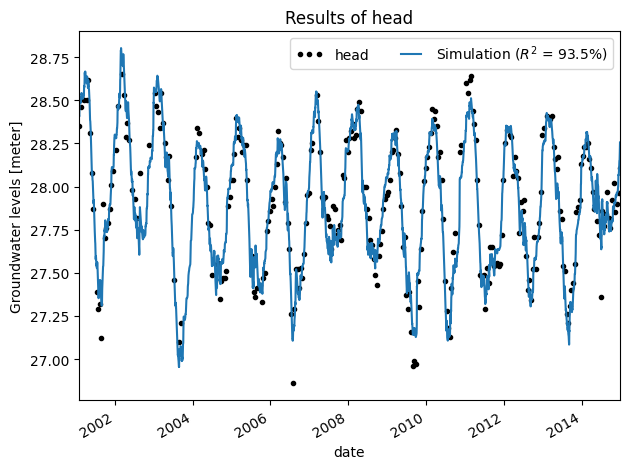

In [ ]:
#%%
# create model with exponential response function
mlexp = ps.Model(head, noisemodel=False)
mlexp.add_stressmodel(ps.RechargeModel(prec=prec, evap=evap, rfunc=ps.Exponential(), name="test_exp"))
mlexp.solve(tmin=tmin, tmax=tmax, noise=False)
mlexp.plot()


In [ ]:
#%%
# extract resistance and sy from exponential model
mlexp_c = mlexp.parameters.loc["test_exp_A", "optimal"]
mlexp_c_i = mlexp.parameters.loc["test_exp_A", "initial"]
mlexp_sy = mlexp.parameters.loc["test_exp_a", "optimal"] / mlexp.parameters.loc["test_exp_A", "optimal"]
mlexp_sy_i = mlexp.parameters.loc["test_exp_a", "initial"] / mlexp.parameters.loc["test_exp_A", "initial"]
mlexp_d = mlexp.parameters.loc["constant_d", "optimal"]
mlexp_d_i = mlexp.parameters.loc["constant_d", "initial"]
mlexp_f = mlexp.parameters.loc["test_exp_f", "optimal"]
mlexp_f_i = mlexp.parameters.loc["test_exp_f", "initial"]



  if hasattr(offset, "delta"):

INFO: Time Series 'rain' was extended in the past to 1976-01-04 00:00:00 with the mean value (0.0021) of the time series.
INFO: Time Series 'evap' was extended in the past to 1976-01-04 00:00:00 with the mean value (0.0016) of the time series.
  return Series(

  return Series(



<Axes: title={'center': 'Results of head'}, xlabel='date', ylabel='Groundwater levels [meter]'>

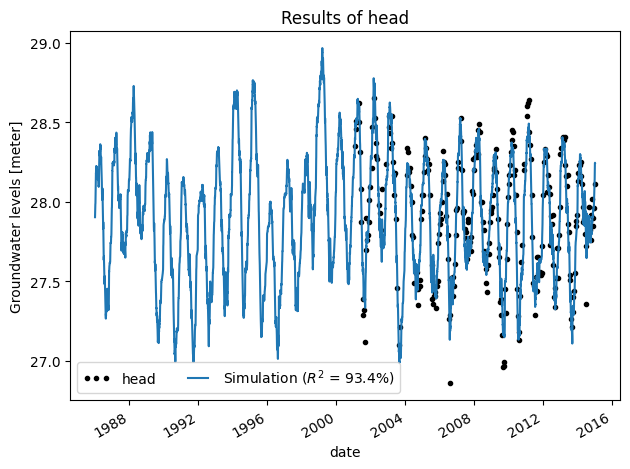

In [ ]:
#%%
# create modflow pastas model with c and sy
mlexpmf = ps.Model(head, noisemodel=False)
expmf = ppmf.ModflowRch(exe_name=mf6_exe, sim_ws="mf_files/test_expmf")
expsm = ppmf.ModflowModel([prec, evap], modflow=expmf, name="test_expmfsm")
mlexpmf.add_stressmodel(expsm)
mlexpmf.set_parameter(f"{expsm.name}_sy", initial=mlexp_sy, vary=False)
mlexpmf.set_parameter(f"{expsm.name}_c", initial=mlexp_c, vary=False)
mlexpmf.set_parameter(f"{expsm.name}_f", initial=mlexp_f, vary=False)
mlexpmf.set_parameter("constant_d", initial=mlexp_d, vary=False)
# mlexpmf.solve(noise=False)
mlexpmf.plot()

In [ ]:
#%%
ml = ps.Model(head, constant=True, noisemodel=False)
mf = ppmf.ModflowRch(exe_name=mf6_exe, sim_ws="mf_files/test_mfrch")
sm = ppmf.ModflowModel([prec, evap], modflow=mf, name="test_mfsm")
ml.add_stressmodel(sm)
ml.set_parameter(f"{sm.name}_sy", initial=mlexp_sy_i, vary=True)
ml.set_parameter(f"{sm.name}_c", initial=mlexp_c_i, vary=True)
ml.set_parameter(f"{sm.name}_f", initial=mlexp_f_i, vary=True)
ml.set_parameter("constant_d", initial=mlexp_d_i, vary=True)
solver = ps.LeastSquares(method="lm")
with SolveTimer() as st:
    ml.solve(noise=False, solver=solver, callback=st.timer, report=False)
ml.fit.result

  if hasattr(offset, "delta"):

Optimization progress: 0it [00:00, ?it/s]

  return Series(

Optimization progress: 1it [00:03,  3.45s/it]WARNING: /home/martin/pastas-plugins/pastas_plugins/modflow/stressmodels.py:100: DeprecationWarning: The 'fastpath' keyword in pd.Series is deprecated and will be removed in a future version.
  return Series(

Optimization progress: 2it [00:06,  3.29s/it]WARNING: /home/martin/pastas-plugins/pastas_plugins/modflow/stressmodels.py:100: DeprecationWarning: The 'fastpath' keyword in pd.Series is deprecated and will be removed in a future version.
  return Series(

Optimization progress: 3it [00:09,  3.21s/it]WARNING: /home/martin/pastas-plugins/pastas_plugins/modflow/stressmodels.py:100: DeprecationWarning: The 'fastpath' keyword in pd.Series is deprecated and will be removed in a future version.
  return Series(

Optimization progress: 4it [00:12,  3.17s/it]WARNING: /home/martin/pastas-plugins/pastas_plugins/modflow/stressmodels.py:100: DeprecationWarning: The 'fastpath' keyword in pd.Series is deprecated and will be removed i

In [ ]:
#%%
ml.plot()


  return Series(

  return Series(



<Axes: title={'center': 'Results of head'}, xlabel='date', ylabel='Groundwater levels [meter]'>

Error in callback <function flush_figures at 0x7f65b1bbf010> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
#%%
ml.parameters

In [ ]:
#%%
mlexp.parameters


In [ ]:
#%%
ax = ml.plot()
mlexp.plot(ax=ax)

In [ ]:
#%%
ax = mlexpmf.plot()
mlexp.plot(ax=ax)


In [ ]:
#%%